This notebook aims to develop a machine learning model for predicting credit card fraud. The primary goal is to create an efficient and accurate system that can identify potentially fraudulent transactions, providing a valuable tool for financial institutions to enhance security measures.

In [1]:
# Import the packages

import pandas as pd
import numpy as np
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import ensemble
import tensorflow as tf
import xgboost as xgb
from sklearn import metrics
import os 
from scipy.stats import shapiro, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler



In [2]:
# Load the dataset (Modify the working directory before running the below code)
cc_df = pd.read_csv(r'Data\creditcard.csv')

In [3]:
# Explore the data

cc_df.head(5)
cc_df.shape
cc_df.info()  # Class has to be modified
cc_df['Class'] = cc_df['Class'].astype('object')
cc_df.describe() # To study the variance we will be needing the histplot
cc_df.isna().sum() # No missing values found


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# Before we commence EDA we will divide the dataset into test and train to ensure that 
# any patterns in test data are not captured in the EDA of train data.

cc_train, cc_test = train_test_split(cc_df, test_size=0.2, random_state=42, stratify= cc_df['Class'])

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


c:\Users\aksha\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\aksha\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\aksha\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\aksha\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\aksha\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\aksha\anaconda3\Lib\site-packages\sc

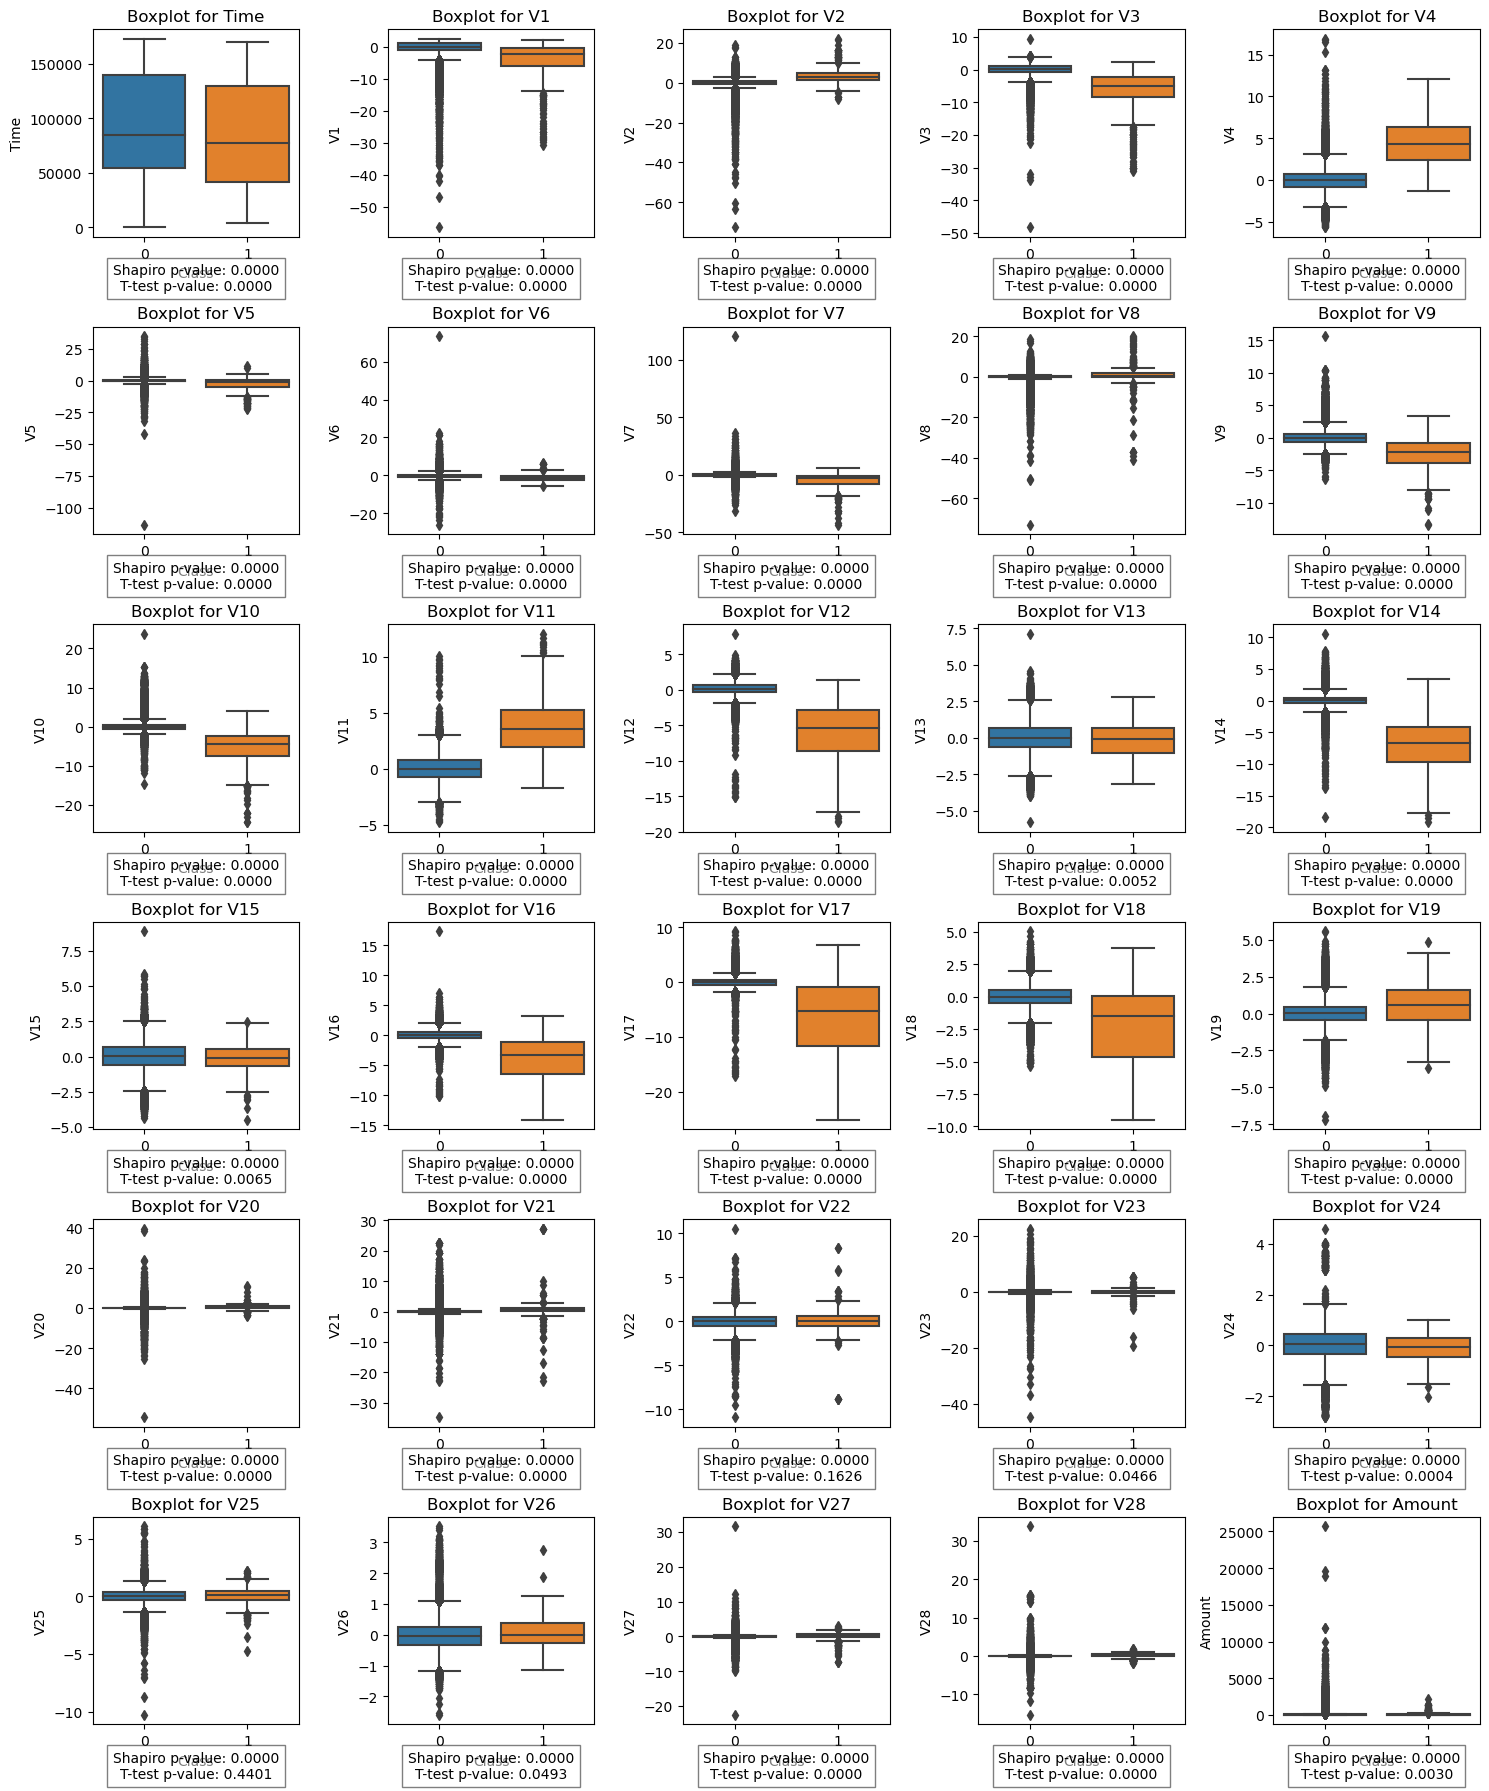

In [11]:
# Study the variance and outliers in each of the columns

column_list = cc_train.select_dtypes(include = ['int64', 'float64']).columns
print(column_list)

# Boxplot for each variable by prediction class 

# Create a subplot grid
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 18))

# Flatten the 2D array of subplots for easy indexing
axes = axes.flatten()

# Loop through each variable
for i, variable in enumerate(column_list):
    # Boxplot
    sns.boxplot(x='Class', y=variable, data=cc_train, ax=axes[i])
    axes[i].set_title(f'Boxplot for {variable}')

    # Shapiro-Wilk normality test for the entire column
    _, shapiro_p_value = shapiro(cc_train[variable])
    
    # Two-sample t-test
    t_stat, t_p_value = ttest_ind(cc_train[cc_train['Class'] == 0][variable], 
                                  cc_train[cc_train['Class'] == 1][variable])

    # Print p-values below each subplot
    axes[i].text(0.5, -0.2, f'Shapiro p-value: {shapiro_p_value:.4f}\nT-test p-value: {t_p_value:.4f}',
                 transform=axes[i].transAxes, ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=0.5))

# Hide empty subplots and adjust layout
for i in range(len(column_list), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()

# Show the plot
plt.show()



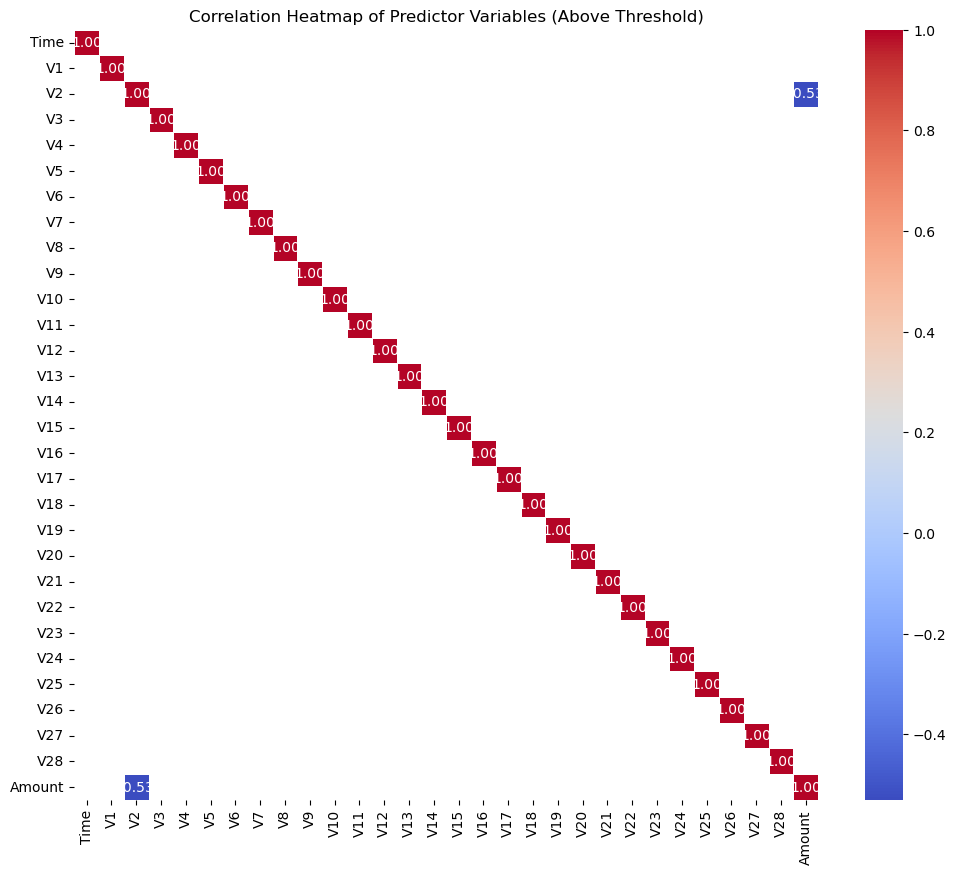

In [12]:
# All the columns have a significant p value hence we won't be dropping any variable.

# Now we will check for multicollinearity since we have lot of variables. We can use a correlation pairplot 
# since all the variables are numeric

# We will print the heatmap of variables with greater than 0.5 correlation 

# Extract the relevant columns from your DataFrame
subset_df = cc_train[column_list]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Create a heatmap using Seaborn
threshold = 0.5  # Set your desired threshold
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[correlation_matrix.abs() > threshold], 
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Predictor Variables (Above Threshold)')
plt.show()




In [13]:


# We noticed that Amount and V2 are highly correlated > 0.5 so we can drop one of the 
# columns to reduce the multicollinearity

cc_df.drop(['V2'], inplace = True, axis = 1) # Later we will again subset the train and test data 
# from the same dataframe and delete the test and train created initiaaly for EDA. Hence we can just 
# drop the column from this dataset.



In [19]:
# We can see that there are lots of outliers in the data, so we will have to treat the same. 
# We will be using the Robust scaler to scale the data. 

X = cc_df.drop(['Class'], axis=1)
y = cc_df['Class']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a RobustScaler object
robust_scaler = RobustScaler()


# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

# Convert the scaled data back to DataFrame with the original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Accuracy: 0.9992
Confusion Matrix:
[[56832    32]
 [   14    84]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.86      0.79        98

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Recall: 0.8571
F1 Score: 0.7850


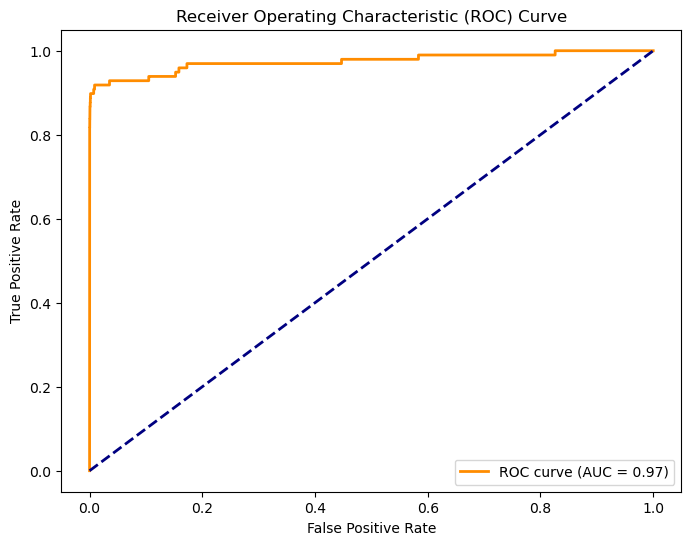

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, f1_score


# Define XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Use logloss for binary classification
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handling class imbalance
    'gamma': 0,
    'seed': 42
}

# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train_scaled_df, label=y_train)
dtest = xgb.DMatrix(X_test_scaled_df, label=y_test)

# Train the XGBoost model
num_round = 100  # Adjust as needed
model = xgb.train(xgb_params, dtrain, num_round)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Convert y_test to a list before calculating accuracy
accuracy = accuracy_score(list(y_test), y_pred_binary)
conf_matrix = confusion_matrix(list(y_test), y_pred_binary)
class_report = classification_report(list(y_test), y_pred_binary)

# Extracting recall and f1-score from the classification report
recall = recall_score(list(y_test), y_pred_binary)
f1_score = f1_score(list(y_test), y_pred_binary)

# Print performance metrics
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

# Print the ROC curve 

# Assuming y_test and y_pred_binary are available
fpr, tpr, thresholds = roc_curve(list(y_test), y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()